In [1]:
# To use the notebook click the 5th button down on the left side (files) and upload/drag in the dataset
# https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients
# https://docs.google.com/document/d/10lkpj3VBcnk7D2TW_EHuu2abu0K4tcxd5Ax39CK03sQ/edit?usp=sharing
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.base import ClassifierMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [2]:
df = pd.read_excel("./default of credit card clients.xls", header=1)
df.set_index("ID", inplace=True)
df.rename(
    columns={
        "default payment next month": "DEFAULT",
        "PAY_0": "PAY_SEPT",
        "PAY_2": "PAY_AUG",
        "PAY_3": "PAY_JUL",
        "PAY_4": "PAY_JUN",
        "PAY_5": "PAY_MAY",
        "PAY_6": "PAY_APR",
        "BILL_AMT1": "BILL_AMT_SEPT",
        "BILL_AMT2": "BILL_AMT_AUG",
        "BILL_AMT3": "BILL_AMT_JUL",
        "BILL_AMT4": "BILL_AMT_JUN",
        "BILL_AMT5": "BILL_AMT_MAY",
        "BILL_AMT6": "BILL_AMT_APR",
        "PAY_AMT1": "PAY_AMT_SEPT",
        "PAY_AMT2": "PAY_AMT_AUG",
        "PAY_AMT3": "PAY_AMT_JUL",
        "PAY_AMT4": "PAY_AMT_JUN",
        "PAY_AMT5": "PAY_AMT_MAY",
        "PAY_AMT6": "PAY_AMT_APR",
    },
    inplace=True,
)

In [3]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   LIMIT_BAL      30000 non-null  int64
 1   SEX            30000 non-null  int64
 2   EDUCATION      30000 non-null  int64
 3   MARRIAGE       30000 non-null  int64
 4   AGE            30000 non-null  int64
 5   PAY_SEPT       30000 non-null  int64
 6   PAY_AUG        30000 non-null  int64
 7   PAY_JUL        30000 non-null  int64
 8   PAY_JUN        30000 non-null  int64
 9   PAY_MAY        30000 non-null  int64
 10  PAY_APR        30000 non-null  int64
 11  BILL_AMT_SEPT  30000 non-null  int64
 12  BILL_AMT_AUG   30000 non-null  int64
 13  BILL_AMT_JUL   30000 non-null  int64
 14  BILL_AMT_JUN   30000 non-null  int64
 15  BILL_AMT_MAY   30000 non-null  int64
 16  BILL_AMT_APR   30000 non-null  int64
 17  PAY_AMT_SEPT   30000 non-null  int64
 18  PAY_AMT_AUG    30000 non-null  int64
 19  PAY_AMT_J

In [5]:
df["DEFAULT"].value_counts()

DEFAULT
0    23364
1     6636
Name: count, dtype: int64

In [6]:
df["EDUCATION"].value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

In [7]:
df["MARRIAGE"].value_counts()

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

EDUCATION has categories 5 and 6 that are unlabelled, moreover category 0 is undocumented. MARRIAGE has a label 0 that is undocumented.
We remove all this undocumented Data

In [8]:
df = df[df["EDUCATION"].isin([1, 2, 3, 4])]
df = df[df["MARRIAGE"].isin([1, 2, 3])]

We also recode the undocumented values in Pay_cols as zeros.

In [9]:
pay_cols = ["PAY_SEPT", "PAY_AUG", "PAY_JUL", "PAY_JUN", "PAY_MAY", "PAY_APR"]

# Replace -2, -1,  with 0 in the specified columns
df[pay_cols] = df[pay_cols].replace({-2: 0, -1: 0})

Our categorical features are already nicely mapped to integers, so we will plot and perform some explanations of these features

In [10]:
categorical_features = ["SEX", "MARRIAGE", "EDUCATION"]
df_categorical = df[categorical_features].copy()
df_categorical["DEFAULT"] = df["DEFAULT"]

In [11]:
df_categorical = df_categorical.replace(
    {
        "SEX": {1: "M", 2: "F"},
        "MARRIAGE": {1: "Married", 2: "Single", 3: "Other"},
        "EDUCATION": {1: "Graduate school", 2: "University", 3: "High school", 4: "Other"},
    },
)

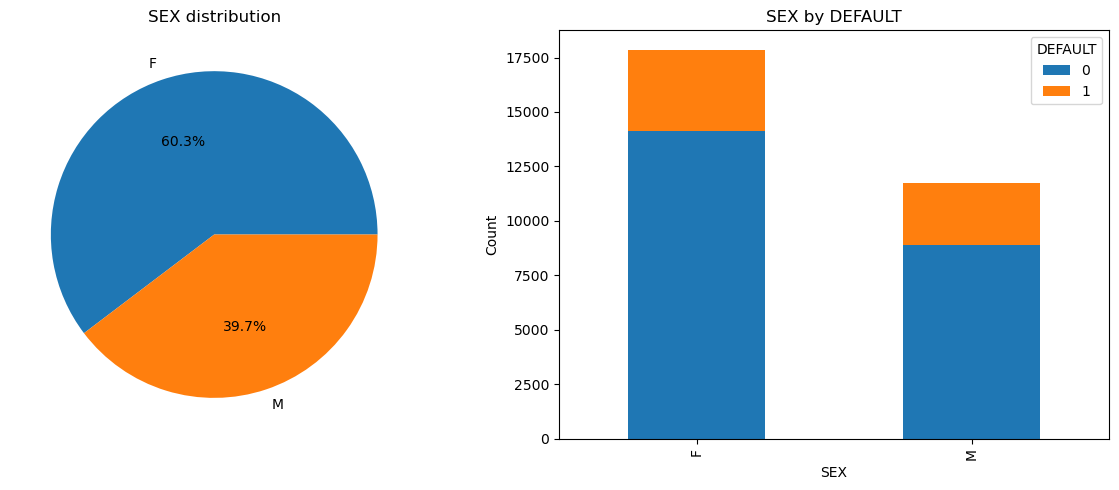

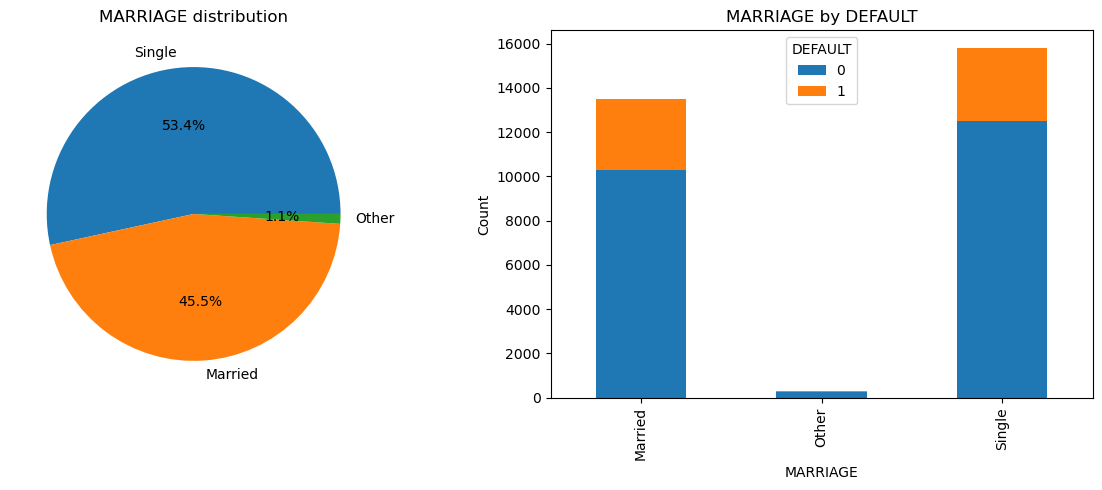

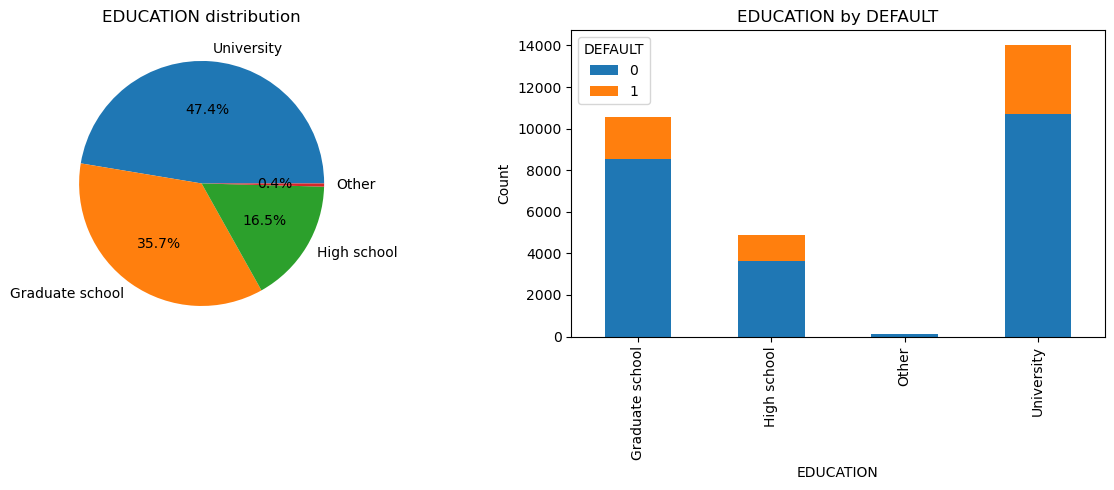

In [12]:
for col in categorical_features:
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    # Pie chart of the overall distribution
    df_categorical[col].value_counts().plot(
        kind="pie",
        ax=axs[0],
        autopct="%1.1f%%",  # shows percentage
    )
    axs[0].set_title(f"{col} distribution")
    axs[0].set_ylabel("")  # hide 'Count' label for a pie chart

    # Bar chart comparing distribution by DEFAULT status.
    cross_tab = pd.crosstab(df_categorical[col], df_categorical["DEFAULT"])
    cross_tab.plot(kind="bar", stacked=True, ax=axs[1])
    axs[1].set_title(f"{col} by DEFAULT")
    axs[1].set_xlabel(col)
    axs[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

# Correlation matrix

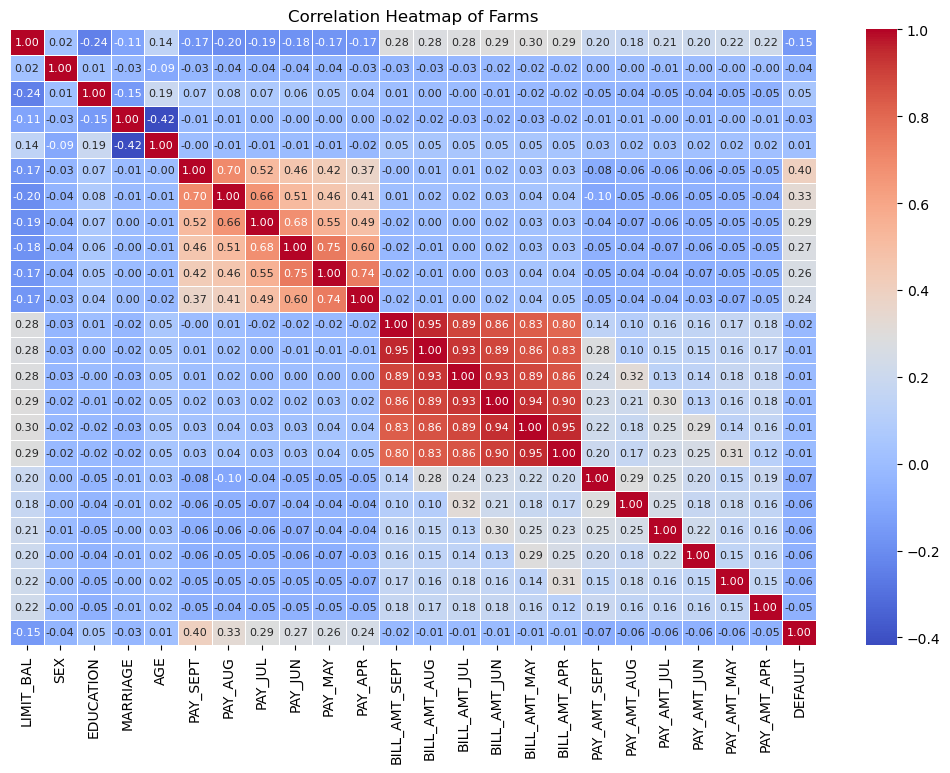

In [13]:
# Compute correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(13, 8))
sns.heatmap(
    corr_matrix, annot=True, annot_kws={"size": 8}, cmap="coolwarm", fmt=".2f", linewidths=0.5, yticklabels=False
)
plt.title("Correlation Heatmap of Farms")
plt.show()

Below we show that there are only Negative values in the bill columns these indicate overpayment by card holders and are credit in their favour.

In [14]:
bill_cols = ["BILL_AMT_SEPT", "BILL_AMT_AUG", "BILL_AMT_JUL", "BILL_AMT_JUN", "BILL_AMT_MAY", "BILL_AMT_APR"]
pay_amt_cols = ["PAY_AMT_SEPT", "PAY_AMT_AUG", "PAY_AMT_JUL", "PAY_AMT_JUN", "PAY_AMT_MAY", "PAY_AMT_APR"]
df[df[bill_cols + pay_amt_cols] < 0].count()

LIMIT_BAL          0
SEX                0
EDUCATION          0
MARRIAGE           0
AGE                0
PAY_SEPT           0
PAY_AUG            0
PAY_JUL            0
PAY_JUN            0
PAY_MAY            0
PAY_APR            0
BILL_AMT_SEPT    588
BILL_AMT_AUG     665
BILL_AMT_JUL     649
BILL_AMT_JUN     667
BILL_AMT_MAY     649
BILL_AMT_APR     679
PAY_AMT_SEPT       0
PAY_AMT_AUG        0
PAY_AMT_JUL        0
PAY_AMT_JUN        0
PAY_AMT_MAY        0
PAY_AMT_APR        0
DEFAULT            0
dtype: int64

Build the feature and target variables

In [15]:
X = df.drop("DEFAULT", axis=1)
y = df["DEFAULT"]

This will Transform the  Variables, it is optional. The one-hot encoder transforms a categorical variable that has multiple categories into multiple binary (0 or 1) columns. This is better for than the Label encoding currently used as label encoding implies order (0 < 1 < 2). The robust Scaler is used here as it is more applicable to fiancial data where the data is not normally distributed. This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [16]:
numeric_features = [col for col in X.columns if col not in categorical_features]

# Set up the transformer
preprocessor = ColumnTransformer(
    transformers=[("num", RobustScaler(), numeric_features), ("cat", OneHotEncoder(drop="first"), categorical_features)]
)

X_Scaled = pd.DataFrame(preprocessor.fit_transform(X))

# Split train/test for scaled data
X_train_Scaled, X_test_scaled, y_train, y_test = train_test_split(X_Scaled, y, test_size=0.2, random_state=42)
X_Scaled

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.631579,-0.769231,2.0,2.0,0.0,0.0,0.0,0.0,-0.290768,-0.296529,...,-0.437956,-0.403660,-0.396511,-0.388400,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.105263,-0.615385,0.0,2.0,0.0,0.0,0.0,2.0,-0.310278,-0.319279,...,-0.194647,-0.134553,-0.396511,0.129467,1.0,1.0,0.0,1.0,0.0,0.0
2,-0.263158,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.110627,-0.116031,...,-0.194647,-0.134553,-0.132170,0.906266,1.0,1.0,0.0,1.0,0.0,0.0
3,-0.473684,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.391964,0.449105,...,-0.145985,-0.107643,-0.113931,-0.129467,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.473684,1.769231,0.0,0.0,0.0,0.0,0.0,0.0,-0.216214,-0.254101,...,1.995134,2.018299,-0.214380,-0.212584,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29596,0.421053,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,2.641873,2.837824,...,0.779319,0.416308,0.925192,-0.129467,0.0,0.0,0.0,0.0,1.0,0.0
29597,0.052632,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,-0.326111,-0.317577,...,1.751338,-0.368945,-0.396511,-0.388400,0.0,1.0,0.0,0.0,1.0,0.0
29598,-0.578947,0.230769,4.0,3.0,2.0,0.0,0.0,0.0,-0.296283,-0.292332,...,4.914842,0.726588,0.132170,0.414293,0.0,1.0,0.0,1.0,0.0,0.0
29599,-0.315789,0.538462,1.0,0.0,0.0,0.0,0.0,0.0,-0.378857,0.947164,...,-0.151338,0.114639,13.604018,0.078716,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# Split train/test for non scaled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEPT,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,...,BILL_AMT_JUL,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEPT,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR
ID,,,,,,,,,,,,,,,,,,,,,
25849,230000,2,2,1,35,0,0,0,0,0,...,150844,151623,148261,153161,10012,10010,10000,7000,10000,10000
16128,60000,2,2,1,36,0,0,0,0,0,...,45728,36441,37336,38138,2100,2000,1700,1500,1400,1500
8825,190000,1,2,2,28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8720,100000,1,1,2,27,0,0,0,0,0,...,65119,61153,64976,66309,4000,2276,2377,5000,2411,2384
9069,30000,2,2,1,34,0,0,0,0,0,...,24135,24745,22805,10745,1260,24135,1000,2000,10745,18572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21831,110000,2,2,2,27,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5442,360000,2,2,1,42,0,0,0,0,0,...,11609,10070,5079,4086,9548,11624,10070,5079,4086,1190
869,140000,2,2,1,39,0,0,0,0,0,...,74510,73876,76180,78400,3000,6000,4000,4000,4000,3000


# Models

In [18]:
model_dict = {}

# Baselines

# Random

In [19]:
random_classifier = DummyClassifier(strategy="stratified", random_state=42)
random_classifier.fit(X_train, y_train)
# Random Stratified Mimics the class distribuion so returns approximaly the same propotion as in the train set

DummyClassifier(random_state=42, strategy='stratified')

# Naive

In [20]:
naive_classifier = DummyClassifier(strategy="most_frequent", random_state=42)
naive_classifier.fit(X_train, y_train)
# Naive always returns the most frequent class label

DummyClassifier(random_state=42, strategy='most_frequent')

# Logistic Regression

In [21]:
logreg_classifier = LogisticRegression(random_state=42, max_iter=1000)
logreg_classifier.fit(X_train_Scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

# KNN

In [22]:
knn_classifier = KNeighborsClassifier(n_neighbors=50)
knn_classifier.fit(X_train_Scaled, y_train)

KNeighborsClassifier(n_neighbors=50)

# Multi Layer Perceptron

In [23]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train_Scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Random Forest

In [24]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# XGBoost

In [25]:
XGBoost_classifier = xgb.XGBClassifier()
XGBoost_classifier.fit(X_train_Scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# K fold cross-validaton

In [26]:
validation_results = {}

In [27]:
def run_cross_validation(model, X, y, num_folds=10, random_state=42):
    """
    Performs K-Fold cross-validation and prints fold-wise results for multiple metrics.

    Parameters:
        model: A scikit-learn compatible model
        X: Features (array-like or DataFrame)
        y: Labels (array-like)
        num_folds: Number of cross-validation folds
        random_state: Random seed for reproducibility

    Returns:
        results: Dictionary of metric name -> list of scores
    """
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    scoring = {
        "roc_auc": "roc_auc",
        "balanced_accuracy": "balanced_accuracy",
        "mcc": make_scorer(matthews_corrcoef),
        "f1_weighted": make_scorer(f1_score, average="weighted"),
    }

    scores = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

    print(f"\nCross-Validation Results ({num_folds} folds):")
    for metric in scoring:
        metric_scores = scores[f"test_{metric}"]
        print(f"  {metric.upper()}:")
        for i, score in enumerate(metric_scores, 1):
            print(f"    Fold {i}: {score:.4f}")
        print(f"    Mean: {metric_scores.mean():.4f}")
        print(f"    Std Dev: {metric_scores.std():.4f}\n")

    return {metric: scores[f"test_{metric}"] for metric in scoring}


validation_results["Random"] = run_cross_validation(random_classifier, X, y)
validation_results["Naive"] = run_cross_validation(naive_classifier, X, y)
validation_results["LogReg"] = run_cross_validation(logreg_classifier, X_Scaled, y)
validation_results["KNN"] = run_cross_validation(knn_classifier, X_Scaled, y)
validation_results["MLP"] = run_cross_validation(mlp_classifier, X_Scaled, y)
validation_results["RF"] = run_cross_validation(random_forest_classifier, X, y)
validation_results["XGB"] = run_cross_validation(XGBoost_classifier, X_Scaled, y)


Cross-Validation Results (10 folds):
  ROC_AUC:
    Fold 1: 0.5132
    Fold 2: 0.5136
    Fold 3: 0.4849
    Fold 4: 0.5030
    Fold 5: 0.5052
    Fold 6: 0.5008
    Fold 7: 0.4929
    Fold 8: 0.4935
    Fold 9: 0.4861
    Fold 10: 0.4818
    Mean: 0.4975
    Std Dev: 0.0109

  BALANCED_ACCURACY:
    Fold 1: 0.5132
    Fold 2: 0.5136
    Fold 3: 0.4849
    Fold 4: 0.5030
    Fold 5: 0.5052
    Fold 6: 0.5008
    Fold 7: 0.4929
    Fold 8: 0.4935
    Fold 9: 0.4861
    Fold 10: 0.4818
    Mean: 0.4975
    Std Dev: 0.0109

  MCC:
    Fold 1: 0.0265
    Fold 2: 0.0273
    Fold 3: -0.0306
    Fold 4: 0.0062
    Fold 5: 0.0104
    Fold 6: 0.0015
    Fold 7: -0.0139
    Fold 8: -0.0128
    Fold 9: -0.0276
    Fold 10: -0.0359
    Mean: -0.0049
    Std Dev: 0.0217

  F1_WEIGHTED:
    Fold 1: 0.6607
    Fold 2: 0.6615
    Fold 3: 0.6334
    Fold 4: 0.6408
    Fold 5: 0.6548
    Fold 6: 0.6630
    Fold 7: 0.6527
    Fold 8: 0.6551
    Fold 9: 0.6449
    Fold 10: 0.6449
    Mean: 0.6512
    Std

# Test Metrics

In [28]:
model_results = {}

In [29]:
def evaluate_model(model, X_train, y_train, X_test, y_test, average="weighted"):
    """
    Train and evaluate a classifier model with comprehensive metrics.

    Parameters:
        model: Any scikit-learn compatible classifier
        X_train, y_train: Training data
        X_test, y_test: Test data
        average: Averaging method for multiclass ("weighted", "macro", "micro")

    Returns:
        dict with evaluation metrics
    """
    if not isinstance(model, ClassifierMixin):
        raise ValueError("Model must be a scikit-learn compatible classifier.")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Basic metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    weighted_precision = precision_score(y_test, y_pred, average=average, zero_division=0)
    weighted_recall = recall_score(y_test, y_pred, average=average, zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_proba)

    # Combine all metrics into a result dictionary
    results = {
        "BalancedAccuracy": balanced_acc,
        "WeightedPrecision": weighted_precision,
        "WeightedRecall": weighted_recall,
        "WeightedF1": weighted_f1,
        "ROC-AUC": auc_score,
        "MCC": mcc,
        "CohenKappa": kappa,
        "Confusion Matrix": cm,
    }

    for test, val in results.items():
        print(f"{test} : {val} ")

    return results


model_results["Random"] = evaluate_model(random_classifier, X_train, y_train, X_test, y_test)
model_results["Naive"] = evaluate_model(naive_classifier, X_train, y_train, X_test, y_test)
model_results["LogReg"] = evaluate_model(logreg_classifier, X_train_Scaled, y_train, X_test_scaled, y_test)
model_results["KNN"] = evaluate_model(knn_classifier, X_train_Scaled, y_train, X_test_scaled, y_test)
model_results["MLP"] = evaluate_model(mlp_classifier, X_train_Scaled, y_train, X_test_scaled, y_test)
model_results["RF"] = evaluate_model(random_forest_classifier, X_train, y_train, X_test, y_test)
model_results["XGB"] = evaluate_model(XGBoost_classifier, X_train_Scaled, y_train, X_test_scaled, y_test)

BalancedAccuracy : 0.49078230863588945 
WeightedPrecision : 0.6451886760766014 
WeightedRecall : 0.6480324269549064 
WeightedF1 : 0.6465981199720016 
ROC-AUC : 0.4907823086358895 
MCC : -0.01858625814021651 
CohenKappa : -0.01858425999836566 
Confusion Matrix : [[3564 1027]
 [1057  273]] 
BalancedAccuracy : 0.5 
WeightedPrecision : 0.6012076019444329 
WeightedRecall : 0.7753757811180544 
WeightedF1 : 0.6772736322513294 
ROC-AUC : 0.5 
MCC : 0.0 
CohenKappa : 0.0 
Confusion Matrix : [[4591    0]
 [1330    0]] 
BalancedAccuracy : 0.6328666907958198 
WeightedPrecision : 0.7892358489905996 
WeightedRecall : 0.8091538591454146 
WeightedF1 : 0.7819476295272532 
ROC-AUC : 0.7559176748230848 
MCC : 0.3591536284677021 
CohenKappa : 0.32660935385504775 
Confusion Matrix : [[4375  216]
 [ 914  416]] 
BalancedAccuracy : 0.6220241302450201 
WeightedPrecision : 0.7828593988925645 
WeightedRecall : 0.8047627090018578 
WeightedF1 : 0.7749076990614174 
ROC-AUC : 0.7585568691932402 
MCC : 0.338007516634

# ROC Curve

In [30]:
def extract_means(data_dict):
    means_dict = {}
    for model_name, metrics_dict in data_dict.items():
        # Compute the mean of each metric array
        means_dict[model_name] = {
            "ROC-AUC": np.mean(metrics_dict["roc_auc"]),
            "Balanced Accuracy": np.mean(metrics_dict["balanced_accuracy"]),
            "MCC": np.mean(metrics_dict["mcc"]),
            "Weighted F1": np.mean(metrics_dict["f1_weighted"]),
        }
    return means_dict


validation_means = extract_means(validation_results)
validation_means

{'Random': {'ROC-AUC': np.float64(0.49751045995672927),
  'Balanced Accuracy': np.float64(0.49751045995672916),
  'MCC': np.float64(-0.004904116927680398),
  'Weighted F1': np.float64(0.6511772862443012)},
 'Naive': {'ROC-AUC': np.float64(0.5),
  'Balanced Accuracy': np.float64(0.5),
  'MCC': np.float64(0.0),
  'Weighted F1': np.float64(0.679334599267243)},
 'LogReg': {'ROC-AUC': np.float64(0.7590585726779665),
  'Balanced Accuracy': np.float64(0.6454526477352418),
  'MCC': np.float64(0.38779931634447656),
  'Weighted F1': np.float64(0.7920343871138662)},
 'KNN': {'ROC-AUC': np.float64(0.7562868333689604),
  'Balanced Accuracy': np.float64(0.6368563635432031),
  'MCC': np.float64(0.36870787022427043),
  'Weighted F1': np.float64(0.7860313277164009)},
 'MLP': {'ROC-AUC': np.float64(0.7138455955552566),
  'Balanced Accuracy': np.float64(0.6406395623130965),
  'MCC': np.float64(0.3085933064610843),
  'Weighted F1': np.float64(0.7672355406032978)},
 'RF': {'ROC-AUC': np.float64(0.765441980

In [31]:
def plot_roc_curves(model_dict, test_data_dict, title="ROC Curves", figsize=(10, 7)):
    """
    Plot ROC curves for multiple trained classifiers.

    Parameters:
        model_dict (dict): Dictionary of model names to trained classifier objects.
        test_data_dict (dict): Dictionary of model names to (X_test, y_test) tuples.
        title (str): Plot title.
        figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)

    for model_name, model in model_dict.items():
        X_test, y_test = test_data_dict.get(model_name, (None, None))
        if X_test is None or y_test is None:
            print(f"Missing test data for {model_name}")
            continue
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

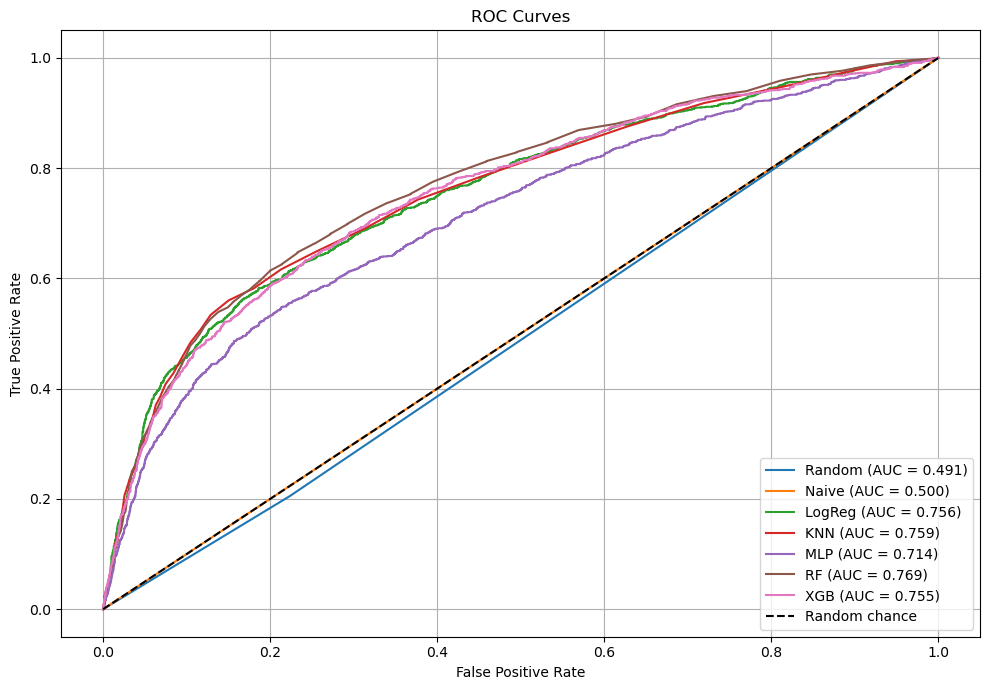

In [32]:
model_dict = {
    "Random": random_classifier,
    "Naive": naive_classifier,
    "LogReg": logreg_classifier,
    "KNN": knn_classifier,
    "MLP": mlp_classifier,
    "RF": random_forest_classifier,
    "XGB": XGBoost_classifier,
}

test_data_dict = {
    "Random": (X_test, y_test),
    "Naive": (X_test, y_test),
    "LogReg": (X_test_scaled, y_test),
    "KNN": (X_test_scaled, y_test),
    "MLP": (X_test_scaled, y_test),
    "RF": (X_test, y_test),
    "XGB": (X_test_scaled, y_test),
}

plot_roc_curves(model_dict, test_data_dict)

# Radar Plot

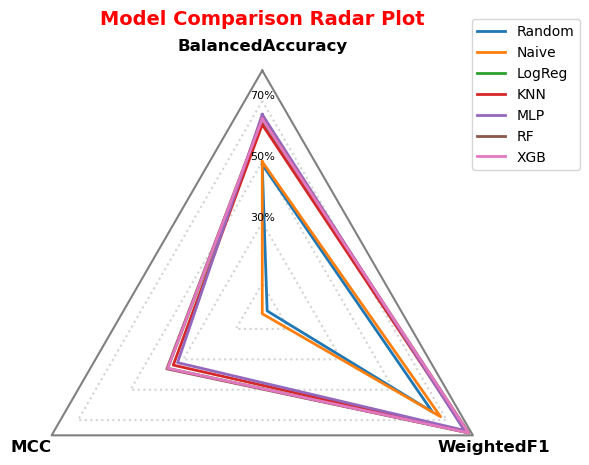

In [33]:
def draw_triangle_radar(
    data_dict, metrics=["BalancedAccuracy", "MCC", "WeightedF1"], title="Model Comparison Radar Plot"
):
    assert len(metrics) == 3, "This plot only works with exactly 3 metrics."

    # Define triangle corners (equilateral triangle in 2D)
    angles_deg = [90, 210, 330]
    angles_rad = [np.deg2rad(a) for a in angles_deg]
    points = np.array([[np.cos(a), np.sin(a)] for a in angles_rad])

    # Create the figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal")

    # Draw triangle outline
    triangle = np.vstack([points, points[0]])  # close the loop
    ax.plot(triangle[:, 0], triangle[:, 1], color="gray", linewidth=1.5)

    # Draw concentric levels
    levels = [0.1, 0.3, 0.5, 0.7]
    for level in levels:
        scaled = points * level * 1.25
        scaled = np.vstack([scaled, scaled[0]])
        ax.plot(scaled[:, 0], scaled[:, 1], color="lightgray", linestyle="dotted")

    # Add axis labels
    for i, label in enumerate(metrics):
        x, y = points[i] * 1.1
        ax.text(x, y, label, ha="center", va="center", fontsize=12, fontweight="bold")

    # Tick labels (percentage rings)
    for level in levels[1:]:
        x, y = points[0] * level * 1.25
        ax.text(x, y, f"{int(level * 100)}%", fontsize=8, va="bottom", ha="center", color="black")

    # Plot each model
    for idx, (model, vals) in enumerate(data_dict.items()):
        values = [vals[m] for m in metrics]
        coords = np.array(points) * np.array(values)[:, None] * 1.25
        polygon = np.vstack([coords, coords[0]])  # close shape
        ax.plot(polygon[:, 0], polygon[:, 1], linewidth=2, label=model)

    # Title and legend
    ax.set_title(title, fontsize=14, fontweight="bold", color="red", pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    ax.axis("off")
    plt.tight_layout()
    plt.show()


draw_triangle_radar(model_results)

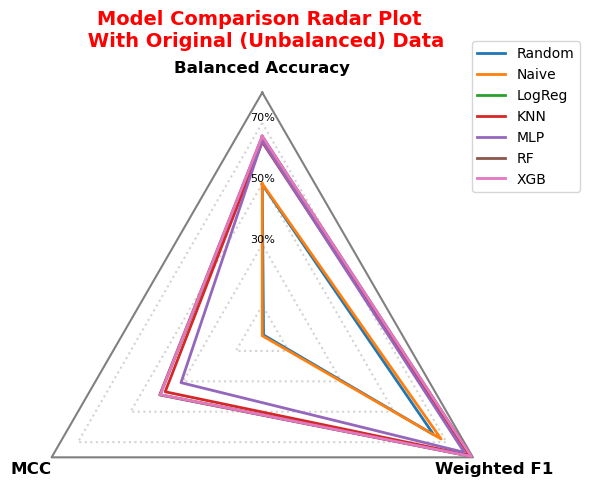

In [34]:
draw_triangle_radar(
    validation_means,
    metrics=["Balanced Accuracy", "MCC", "Weighted F1"],
    title="Model Comparison Radar Plot \n With Original (Unbalanced) Data",
)

# **SMOTE**

In [35]:
# Get current class distribution
class_counts = Counter(y)

# Define desired number of samples for class 1
desired_count_class_1 = class_counts[1] + 500

In [36]:
# For scaled data
# smote_scaled = SMOTE(sampling_strategy={1: desired_count_class_1}, k_neighbors=3, random_state=42)
smote_scaled = SMOTE(random_state=42)
X_resampled_scaled, y_resampled_scaled = smote_scaled.fit_resample(X_train_Scaled, y_train)

# For unscaled data
# smote_unscaled = SMOTE(sampling_strategy={1: desired_count_class_1}, k_neighbors=3, random_state=42)
smote_unscaled = SMOTE(random_state=42)
X_resampled, y_resampled = smote_unscaled.fit_resample(X_train, y_train)


print(len(y_train), y_train.sum())
print(len(y_resampled_scaled), y_resampled_scaled.sum())
print(len(y_resampled), y_resampled.sum())

23680 5275
36810 18405
36810 18405


# Resampled Models

# Random

In [37]:
random_classifier = DummyClassifier(strategy="stratified", random_state=42)
random_classifier.fit(X_resampled, y_resampled)
# Random Stratified Mimics the class distribuion so returns approximaly the same propotion as in the train set

DummyClassifier(random_state=42, strategy='stratified')

# Naive

In [38]:
naive_classifier = DummyClassifier(strategy="most_frequent", random_state=42)
naive_classifier.fit(X_resampled, y_resampled)
# Naive always returns the most frequent class label

DummyClassifier(random_state=42, strategy='most_frequent')

# Logistic Regression

In [39]:
logreg_classifier = LogisticRegression(random_state=42, max_iter=1000)
logreg_classifier.fit(X_resampled_scaled, y_resampled_scaled)

LogisticRegression(max_iter=1000, random_state=42)

# KNN

In [40]:
knn_classifier = KNeighborsClassifier(n_neighbors=50)
knn_classifier.fit(X_resampled_scaled, y_resampled_scaled)

KNeighborsClassifier(n_neighbors=50)

# Multi Layer Perceptron

In [41]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_classifier.fit(X_resampled_scaled, y_resampled_scaled)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Random Forest

In [42]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

# XGBoost

In [43]:
XGBoost_classifier = xgb.XGBClassifier()
XGBoost_classifier.fit(X_resampled_scaled, y_resampled_scaled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# K fold cross-validation

In [44]:
def run_cross_validation_smote(model, X, y, num_folds=10, random_state=42, smote_params=None):
    """
    Performs K-Fold cross-validation with SMOTE applied in each fold and computes multiple metrics.

    Parameters:
        model: A scikit-learn compatible model
        X: Features
        y: Labels
        num_folds: Number of folds
        random_state: Reproducibility
        smote_params: Optional dict of SMOTE parameters

    Returns:
        results: Dictionary of metric name -> list of scores
    """
    smote_params = smote_params or {}
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    metrics = {"roc_auc": [], "balanced_accuracy": [], "mcc": [], "f1_weighted": []}

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE to training data
        smote = SMOTE(**smote_params)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Train model
        model_clone = clone(model)
        model_clone.fit(X_train_resampled, y_train_resampled)
        y_pred = model_clone.predict(X_test)

        # Probabilities for AUC
        if hasattr(model_clone, "predict_proba"):
            y_prob = model_clone.predict_proba(X_test)[:, 1]
            metrics["roc_auc"].append(roc_auc_score(y_test, y_prob))
        else:
            metrics["roc_auc"].append(np.nan)  # fallback if no probas available

        metrics["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
        metrics["mcc"].append(matthews_corrcoef(y_test, y_pred))
        metrics["f1_weighted"].append(f1_score(y_test, y_pred, average="weighted"))

        print(f"Fold {fold}:")
        for k in metrics:
            print(f"  {k.upper()}: {metrics[k][-1]:.4f}")
        print()

    print(f"\nMean Cross-Validation Results ({num_folds} folds):")
    for metric, values in metrics.items():
        mean_val = np.nanmean(values)
        std_val = np.nanstd(values)
        print(f"  {metric.upper()}: {mean_val:.4f} ± {std_val:.4f}")

    return metrics


validation_results_resampled = {}
validation_results_resampled["Random"] = run_cross_validation_smote(random_classifier, X.values, y.values)
validation_results_resampled["Naive"] = run_cross_validation_smote(naive_classifier, X.values, y.values)
validation_results_resampled["LogReg"] = run_cross_validation_smote(logreg_classifier, X_Scaled.values, y.values)
validation_results_resampled["KNN"] = run_cross_validation_smote(knn_classifier, X_Scaled.values, y.values)
validation_results_resampled["MLP"] = run_cross_validation_smote(mlp_classifier, X_Scaled.values, y.values)
validation_results_resampled["RF"] = run_cross_validation_smote(random_forest_classifier, X.values, y.values)
validation_results_resampled["XGB"] = run_cross_validation_smote(XGBoost_classifier, X_Scaled.values, y.values)

Fold 1:
  ROC_AUC: 0.5188
  BALANCED_ACCURACY: 0.5188
  MCC: 0.0313
  F1_WEIGHTED: 0.5557

Fold 2:
  ROC_AUC: 0.4926
  BALANCED_ACCURACY: 0.4926
  MCC: -0.0123
  F1_WEIGHTED: 0.5391

Fold 3:
  ROC_AUC: 0.4926
  BALANCED_ACCURACY: 0.4926
  MCC: -0.0123
  F1_WEIGHTED: 0.5391

Fold 4:
  ROC_AUC: 0.4877
  BALANCED_ACCURACY: 0.4877
  MCC: -0.0204
  F1_WEIGHTED: 0.5360

Fold 5:
  ROC_AUC: 0.4916
  BALANCED_ACCURACY: 0.4916
  MCC: -0.0139
  F1_WEIGHTED: 0.5385

Fold 6:
  ROC_AUC: 0.5028
  BALANCED_ACCURACY: 0.5028
  MCC: 0.0047
  F1_WEIGHTED: 0.5457

Fold 7:
  ROC_AUC: 0.5028
  BALANCED_ACCURACY: 0.5028
  MCC: 0.0047
  F1_WEIGHTED: 0.5457

Fold 8:
  ROC_AUC: 0.5116
  BALANCED_ACCURACY: 0.5116
  MCC: 0.0193
  F1_WEIGHTED: 0.5513

Fold 9:
  ROC_AUC: 0.5077
  BALANCED_ACCURACY: 0.5077
  MCC: 0.0128
  F1_WEIGHTED: 0.5488

Fold 10:
  ROC_AUC: 0.4853
  BALANCED_ACCURACY: 0.4853
  MCC: -0.0245
  F1_WEIGHTED: 0.5345


Mean Cross-Validation Results (10 folds):
  ROC_AUC: 0.4994 ± 0.0105
  BALANCED_ACC

# Model Evaluation

In [45]:
model_results_resampled = {}
model_results_resampled["Random"] = evaluate_model(random_classifier, X_resampled, y_resampled, X_test, y_test)
model_results_resampled["Naive"] = evaluate_model(naive_classifier, X_resampled, y_resampled, X_test, y_test)
model_results_resampled["LogReg"] = evaluate_model(
    logreg_classifier, X_resampled_scaled, y_resampled_scaled, X_test_scaled, y_test
)
model_results_resampled["KNN"] = evaluate_model(
    knn_classifier, X_resampled_scaled, y_resampled_scaled, X_test_scaled, y_test
)
model_results_resampled["MLP"] = evaluate_model(
    mlp_classifier, X_resampled_scaled, y_resampled_scaled, X_test_scaled, y_test
)
model_results_resampled["RF"] = evaluate_model(random_forest_classifier, X_resampled, y_resampled, X_test, y_test)
model_results_resampled["XGB"] = evaluate_model(
    XGBoost_classifier, X_resampled_scaled, y_resampled_scaled, X_test_scaled, y_test
)

BalancedAccuracy : 0.508771247439007 
WeightedPrecision : 0.6577840436161695 
WeightedRecall : 0.5053200472893092 
WeightedF1 : 0.5458748750454955 
ROC-AUC : 0.5087712474390069 
MCC : 0.014642240971737865 
CohenKappa : 0.01220208261863076 
Confusion Matrix : [[2307 2284]
 [ 645  685]] 
BalancedAccuracy : 0.5 
WeightedPrecision : 0.6012076019444329 
WeightedRecall : 0.7753757811180544 
WeightedF1 : 0.6772736322513294 
ROC-AUC : 0.5 
MCC : 0.0 
CohenKappa : 0.0 
Confusion Matrix : [[4591    0]
 [1330    0]] 
BalancedAccuracy : 0.6965663450720025 
WeightedPrecision : 0.7849159879393677 
WeightedRecall : 0.7779091369701064 
WeightedF1 : 0.7811025908409631 
ROC-AUC : 0.7538351432927777 
MCC : 0.38197915405514987 
CohenKappa : 0.3814198294679264 
Confusion Matrix : [[3876  715]
 [ 600  730]] 
BalancedAccuracy : 0.6841133273174222 
WeightedPrecision : 0.7699709850348514 
WeightedRecall : 0.6910994764397905 
WeightedF1 : 0.7139729183216891 
ROC-AUC : 0.7511089857075711 
MCC : 0.315674607932956

# ROC Curve

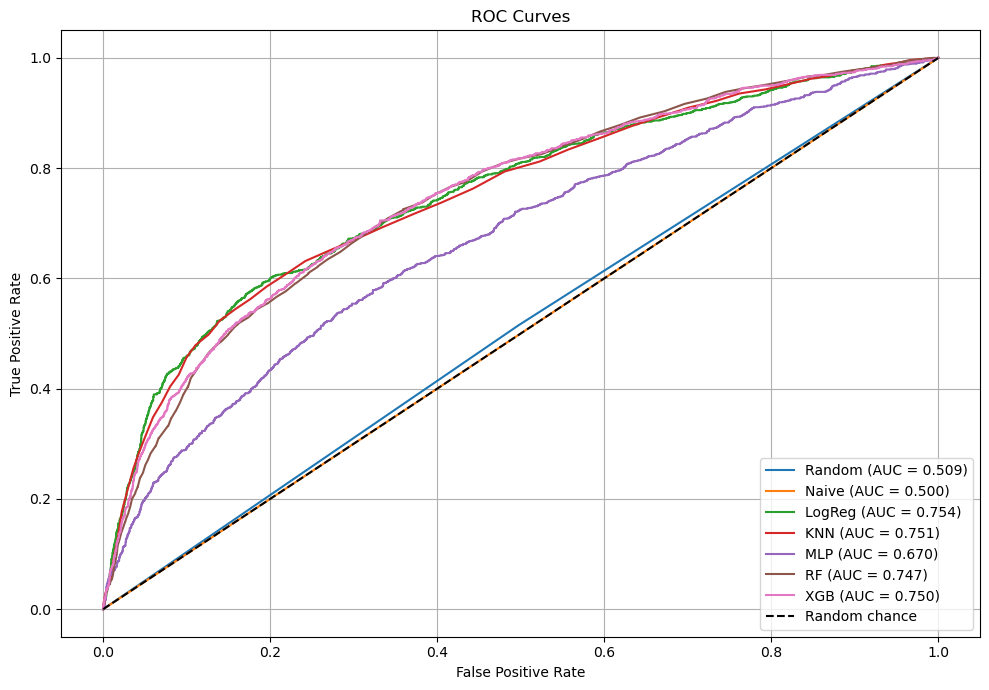

In [46]:
model_dict = {
    "Random": random_classifier,
    "Naive": naive_classifier,
    "LogReg": logreg_classifier,
    "KNN": knn_classifier,
    "MLP": mlp_classifier,
    "RF": random_forest_classifier,
    "XGB": XGBoost_classifier,
}

test_data_dict = {
    "Random": (X_test, y_test),
    "Naive": (X_test, y_test),
    "LogReg": (X_test_scaled, y_test),
    "KNN": (X_test_scaled, y_test),
    "MLP": (X_test_scaled, y_test),
    "RF": (X_test, y_test),
    "XGB": (X_test_scaled, y_test),
}

plot_roc_curves(model_dict, test_data_dict)

# Radar plot resampled

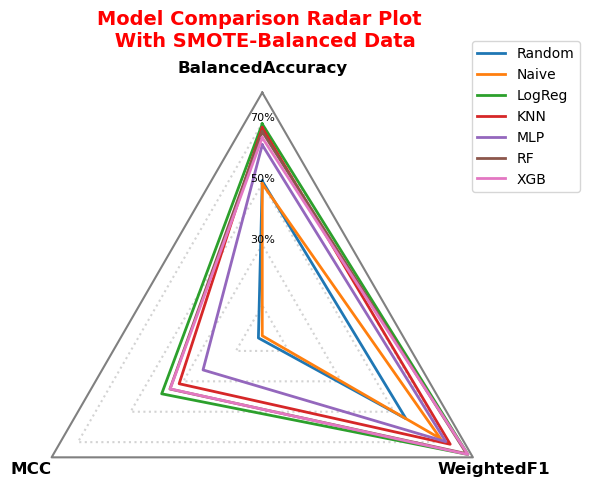

In [47]:
def draw_triangle_radar(
    data_dict, metrics=["BalancedAccuracy", "MCC", "WeightedF1"], title="Model Comparison Radar Plot"
):
    assert len(metrics) == 3, "This plot only works with exactly 3 metrics."

    # Define triangle corners (equilateral triangle in 2D)
    angles_deg = [90, 210, 330]
    angles_rad = [np.deg2rad(a) for a in angles_deg]
    points = np.array([[np.cos(a), np.sin(a)] for a in angles_rad])

    # Create the figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal")

    # Draw triangle outline
    triangle = np.vstack([points, points[0]])  # close the loop
    ax.plot(triangle[:, 0], triangle[:, 1], color="gray", linewidth=1.5)

    # Draw concentric levels
    levels = [0.1, 0.3, 0.5, 0.7]
    for level in levels:
        scaled = points * level * 1.25
        scaled = np.vstack([scaled, scaled[0]])
        ax.plot(scaled[:, 0], scaled[:, 1], color="lightgray", linestyle="dotted")

    # Add axis labels
    for i, label in enumerate(metrics):
        x, y = points[i] * 1.1
        ax.text(x, y, label, ha="center", va="center", fontsize=12, fontweight="bold")

    # Tick labels (percentage rings)
    for level in levels[1:]:
        x, y = points[0] * level * 1.25
        ax.text(x, y, f"{int(level * 100)}%", fontsize=8, va="bottom", ha="center", color="black")

    # Plot each model
    for model, vals in data_dict.items():
        values = [vals[m] for m in metrics]
        coords = np.array(points) * np.array(values)[:, None] * 1.25
        polygon = np.vstack([coords, coords[0]])  # close shape
        ax.plot(polygon[:, 0], polygon[:, 1], linewidth=2, label=model)

    # Title and legend
    ax.set_title(title, fontsize=14, fontweight="bold", color="red", pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    ax.axis("off")
    plt.tight_layout()
    plt.show()


draw_triangle_radar(model_results_resampled, title="Model Comparison Radar Plot \n With SMOTE-Balanced Data")

In [48]:
validation_results_resampled

{'Random': {'roc_auc': [np.float64(0.518785437084786),
   np.float64(0.49260120331210244),
   np.float64(0.49260120331210244),
   np.float64(0.4877316257347962),
   np.float64(0.4916272877966412),
   np.float64(0.5028260869565218),
   np.float64(0.5028260869565218),
   np.float64(0.511600790513834),
   np.float64(0.5077009222661396),
   np.float64(0.4852766798418972)],
  'balanced_accuracy': [np.float64(0.518785437084786),
   np.float64(0.49260120331210244),
   np.float64(0.49260120331210244),
   np.float64(0.4877316257347962),
   np.float64(0.4916272877966412),
   np.float64(0.5028260869565218),
   np.float64(0.5028260869565218),
   np.float64(0.511600790513834),
   np.float64(0.5077009222661397),
   np.float64(0.48527667984189726)],
  'mcc': [np.float64(0.03129125747391455),
   np.float64(-0.012325834829383561),
   np.float64(-0.012325834829383561),
   np.float64(-0.020438182206751674),
   np.float64(-0.013948304304857185),
   np.float64(0.004705507189244835),
   np.float64(0.0047055

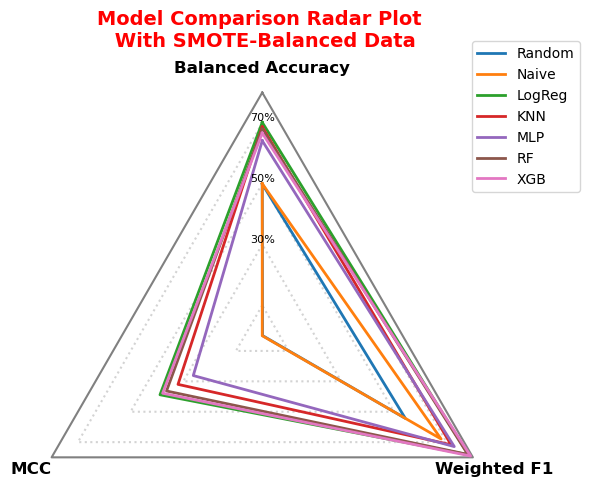

In [49]:
validation_means_resampled = extract_means(validation_results_resampled)
draw_triangle_radar(
    validation_means_resampled,
    metrics=["Balanced Accuracy", "MCC", "Weighted F1"],
    title="Model Comparison Radar Plot \n With SMOTE-Balanced Data",
)